<a href="https://colab.research.google.com/github/kwanhong66/KaggleShoveling/blob/master/NYC_Airbnb_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset with Kaggle API

In [0]:
!pip3 install -q kaggle

In [0]:
!wget 'https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json'

--2020-06-10 06:27:10--  https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      63  --.-KB/s    in 0s      

2020-06-10 06:27:10 (3.25 MB/s) - ‘kaggle.json’ saved [63/63]



In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download dgomonov/new-york-city-airbnb-open-data

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 82.2MB/s]


In [0]:
!mkdir input

In [0]:
!unzip '*.zip' -d ./input/

Archive:  new-york-city-airbnb-open-data.zip
  inflating: ./input/AB_NYC_2019.csv  
  inflating: ./input/New_York_City_.png  


## Notes

These codes are originated from below kernels:

* https://www.kaggle.com/dgomonov/data-exploration-on-nyc-airbnb
* https://www.kaggle.com/mpanfil/nyc-airbnb-data-science-ml-project

Based on these, original code will be added more and more.

## 1. Preparing Data

### Import packages

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load data

In [0]:
nyc_airbnb = pd.read_csv('./input/AB_NYC_2019.csv')

nyc_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


**Checking dataset size**

The dataset has 48,895 records and 16 features

In [0]:
print("The number of records(examples): {}".format(nyc_airbnb.shape[0]))
print("The number of columns(features): {}".format(nyc_airbnb.shape[1]))

The number of records(examples): 48895
The number of columns(features): 16


### Observe data

**Checking column dtype**

The columns which have numerical values are as follows:

`latitude`, `longitude`, `price`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `calculated_host_listings_count`, `availability_365`

In [0]:
# checking type of every column in the dataset
nyc_airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

**Checking null values**

The folling columns have null values:

`name`, `host_name`, `last_review`, `reviews_per_month`

In [0]:
print("Null values in NYC Airbnb 2019 dataset:")
# checking total missing values in each column in the dataset
nyc_airbnb.isnull().sum()

Null values in NYC Airbnb 2019 dataset:


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Especially, there are many missing reviews (`last_review`, `reviews_per_month`).

Numbers of missing values of them are same (10052), which needs to be inspected. There are possibility that missing values are in the same row.

In fact, we can see that review related column are not significant and not difficult to handle.

* **last_review**: The date last review was uploaded. If there were no reivews for the, date will simply missing. This column seems to be insignificant thus could be dropped in data cleansing time.

* **reviews_per_month**: This column means review rate for month. We can easily replace NaN values with 0.0. 


**Inspecting name column null values**

In [0]:
# https://numpy.org/doc/1.18/reference/generated/numpy.where.html
# numpy.where: Return elements chosen from x or y depending on condition.
null_names = pd.DataFrame(np.where(nyc_airbnb['name'].isnull())).transpose()
null_host_names = pd.DataFrame(np.where(nyc_airbnb['host_name'].isnull())).transpose()

concat_null_names = pd.concat([null_names, null_host_names], axis=1, ignore_index=True)
concat_null_names.columns = ['Null rows in name column', 'Null rows in host_name column']
concat_null_names

,Null rows in name column,Null rows in host_name column
0,2854.0,360
1,3703.0,2700
2,5775.0,5745
3,5975.0,6075
4,6269.0,6582
5,6567.0,8163
6,6605.0,8257
7,8841.0,8852
8,11963.0,9138
9,12824.0,9817


**Missing data visualization with `missingno`**

- `msno.bar` is a simple visualization of nullity by column.

- Bar chart shows total records and bar itself representsnon-missing values, thus we could see the how much the nullity of certain column by space.

- Each bar has label which is non-missing values on top of the chart.

Missing value columns: ['name', 'host_name', 'last_review', 'reviews_per_month']


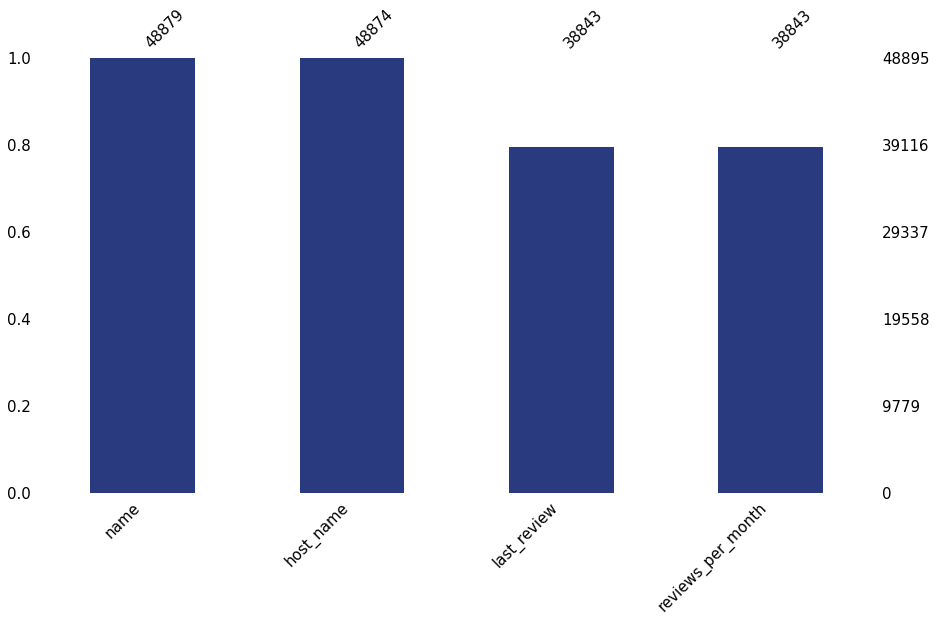

In [0]:
import missingno as msno
missing_value_columns = nyc_airbnb.columns[nyc_airbnb.isnull().any()].tolist()
print("Missing value columns: {}".format(missing_value_columns))
msno.bar(nyc_airbnb[missing_value_columns], figsize=(15,8), color='#2A3A7E', 
         fontsize=15, labels=True)  # Can switch to a logarithmic scale by specifying log=True

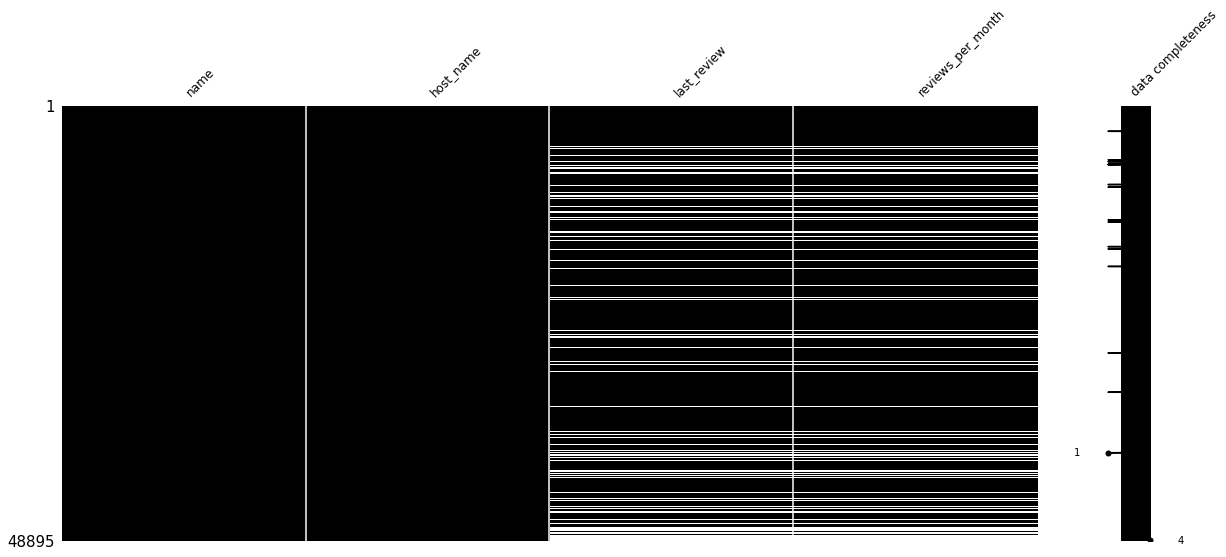

In [0]:
msno.matrix(nyc_airbnb[missing_value_columns], width_ratios=(10, 1),
            figsize=(20, 8), color=(0, 0, 0), fontsize=12, sparkline=True, labels=True)

### Wrangling and cleaning data

**Dropping columns**

The column `last_review` seems to be insignificant for exploration and prediction.

In [0]:
nyc_airbnb.drop(['last_review'], axis=1, inplace=True)

Also, `host_name` column contains actual person names, which might be sensible data.

In [0]:
nyc_airbnb.drop(['host_name'], axis=1, inplace=True)

In [0]:
nyc_airbnb.head(5)

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


**Handling NaN values**

After dropping two columns(`host_name`, `last_review`), dataset has still null values. Replacing all NaN values with zero seems to make sense.

In [0]:
nyc_airbnb['name'].fillna(value=0, inplace=True)

In [0]:
nyc_airbnb['reviews_per_month'].fillna(value=0, inplace=True)

In [0]:
nyc_airbnb.isnull().sum()

id                                0
name                              0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

## Exploring data

### Checking categorical values

As we see above, we could find out three categorical columns, which are `neighbourhood_group`, `neighbourhood` and `room_type`.

`neighbourhood_group` and `neighbourhood` columns have informative area data.

The data could be utilized for analyzing data based on `neighbourhood`. Also, checking unique values in categorical values could help understanding of data.

In [0]:
# check unique category values
# find out which neighbourhood_group exist in dataset
print('Neighbourhood_group: {}'.format(nyc_airbnb['neighbourhood_group'].unique()))

Neighbourhood_group: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


The dataset has five `neighbourhood_gruop` categories, which are `Brooklyn`, `Manhattan`, `Queens`, `Staten Island`, `Bronx`.

In [0]:
# check unique category values
# find out which neighbourhood exist in dataset
nyc_airbnb['neighbourhood'].unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [0]:
nyc_airbnb['neighbourhood'].nunique()

221

`neighbourhood` column has 221 categories.

In [0]:
nyc_airbnb['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

The `room_type` are `Private room`, `Entire home/apt` and `Shared room`.

### Top reviewed

In [0]:
nyc_airbnb.sort_values(by='number_of_reviews', ascending=False).head(5)

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
11759,9145202,Room near JFK Queen Bed,47621202,Queens,Jamaica,40.66730,-73.76831,Private room,47,1,629,14.58,2,333
2031,903972,Great Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82085,-73.94025,Private room,49,1,607,7.75,3,293
2030,903947,Beautiful Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82124,-73.93838,Private room,49,1,597,7.72,3,342
2015,891117,Private Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82264,-73.94041,Private room,49,1,594,7.57,3,339
13495,10101135,Room Near JFK Twin Beds,47621202,Queens,Jamaica,40.66939,-73.76975,Private room,47,1,576,13.40,2,173


In [0]:
nyc_airbnb.sort_values(by='reviews_per_month', ascending=False).head(5)

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
42075,32678719,Enjoy great views of the City in our Deluxe Room!,244361589,Manhattan,Theater District,40.75918,-73.98801,Private room,100,1,156,58.50,9,299
42076,32678720,Great Room in the heart of Times Square!,244361589,Manhattan,Theater District,40.75828,-73.98876,Private room,199,1,82,27.95,9,299
38870,30423106,Lou's Palace-So much for so little,228415932,Queens,Rosedale,40.65417,-73.74158,Private room,45,1,37,20.94,1,134
27287,21550302,JFK Comfort.5 Mins from JFK Private Bedroom & ...,156684502,Queens,Springfield Gardens,40.66110,-73.76830,Private room,80,1,403,19.75,3,26
28651,22176831,JFK 2 Comfort 5 Mins from JFK Private Bedroom,156684502,Queens,Springfield Gardens,40.66158,-73.77050,Private room,50,1,341,17.82,3,25


## Visualization

### 1. Counts of airbnb in neighbourhood group


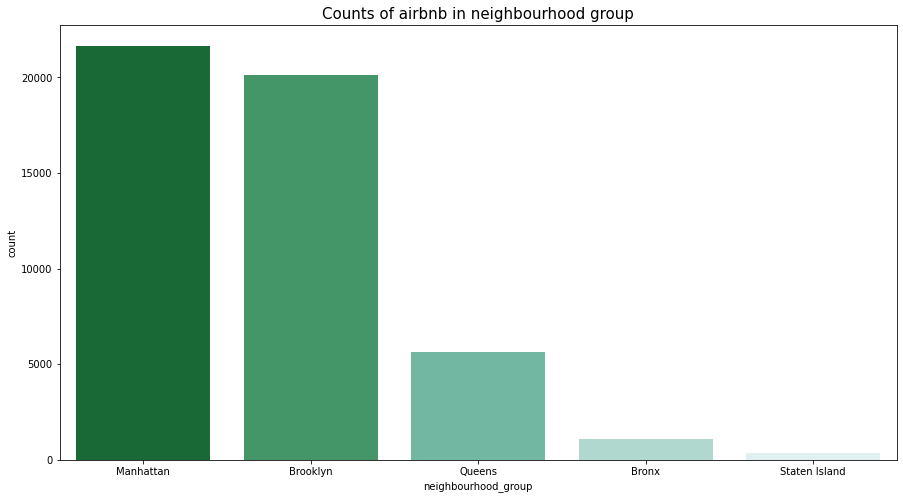

In [0]:
plt.figure(figsize=(15, 8))
plt.title('Counts of airbnb in neighbourhood group', fontsize=15)
sns.countplot(x='neighbourhood_group', data=nyc_airbnb, 
              order=nyc_airbnb['neighbourhood_group'].value_counts().index,
              palette='BuGn_r')

There seems to be that most of airbnb in NYC are in `Manhattan` and `Brooklyn`

### 2. Counts of airbnb in neighbourhood group with room type

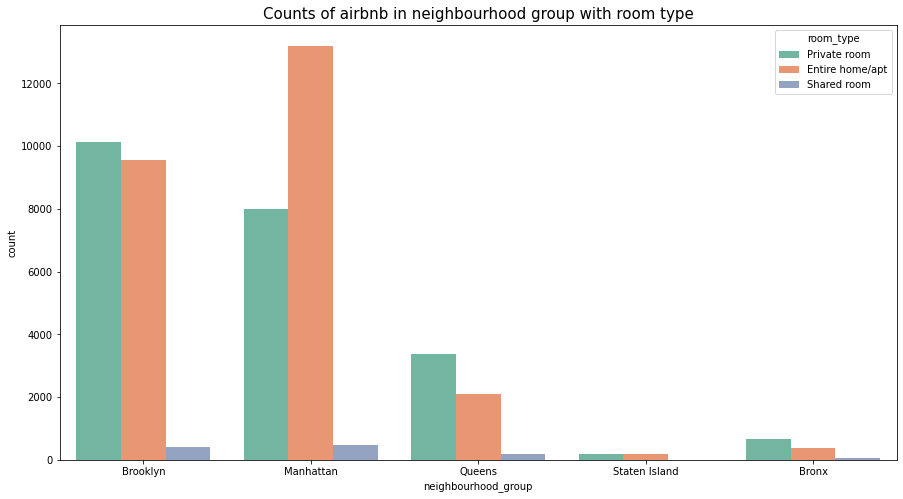

In [0]:
plt.figure(figsize=(15, 8))
plt.title('Counts of airbnb in neighbourhood group with room type', fontsize=15)
sns.countplot(x='neighbourhood_group', data=nyc_airbnb, hue='room_type',
              palette="Set2")

### 3. Top neighbourhoods with  room type

[Text(0, 0, 'Midtown'),
 Text(0, 0, 'Harlem'),
 Text(0, 0, 'Bedford-Stuyvesant'),
 Text(0, 0, "Hell's Kitchen"),
 Text(0, 0, 'Upper West Side'),
 Text(0, 0, 'Williamsburg'),
 Text(0, 0, 'Crown Heights'),
 Text(0, 0, 'East Village'),
 Text(0, 0, 'Bushwick'),
 Text(0, 0, 'Upper East Side')]

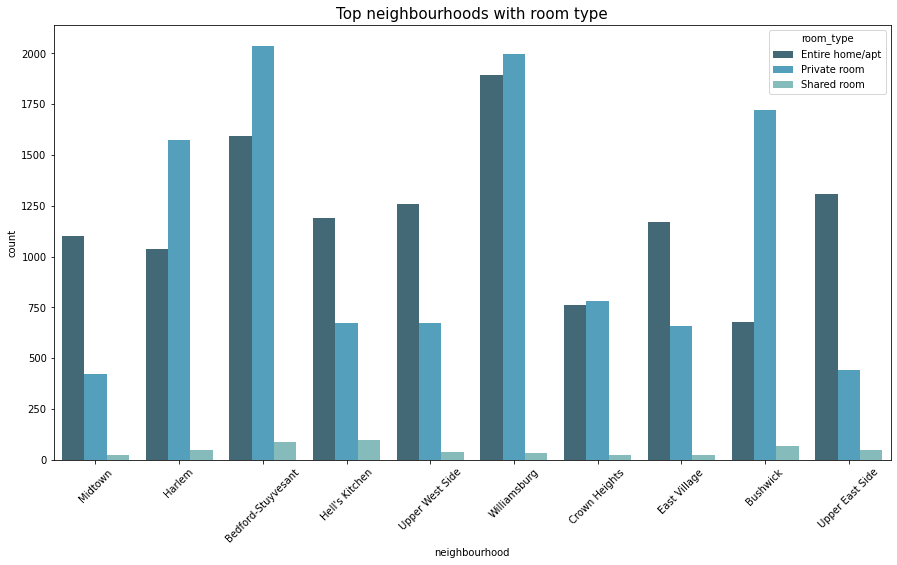

In [0]:
top_neigh = nyc_airbnb['neighbourhood'].value_counts().reset_index().head(10)  # Top 10
top_neigh = top_neigh['index'].tolist()  # get top 10 neighbourhood names

plt.figure(figsize=(15, 8))
plt.title('Top neighbourhoods with room type', fontsize=15)
viz = sns.countplot(x='neighbourhood', data=nyc_airbnb.loc[nyc_airbnb['neighbourhood'].isin(top_neigh)],
              hue='room_type', palette='GnBu_d')
viz.set_xticklabels(viz.get_xticklabels(), rotation=45)

### 4. Price distribution by negihbourhood group

In [0]:
# check wholde dataset price stats
nyc_airbnb['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

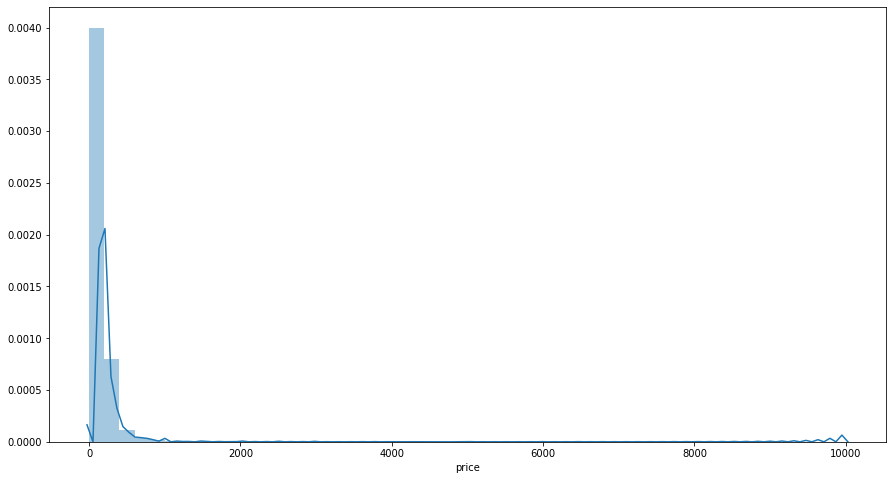

In [0]:
plt.figure(figsize=(15, 8))
sns.distplot(nyc_airbnb['price'])

In [0]:
nyc_airbnb['price'].quantile(.98)

550.0

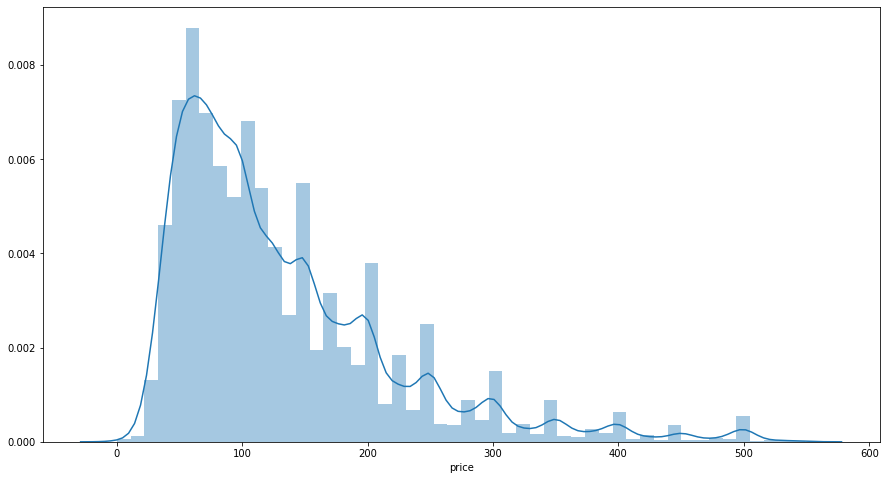

In [0]:
plt.figure(figsize=(15, 8))
sns.distplot(nyc_airbnb[nyc_airbnb['price'] < 550]['price'])

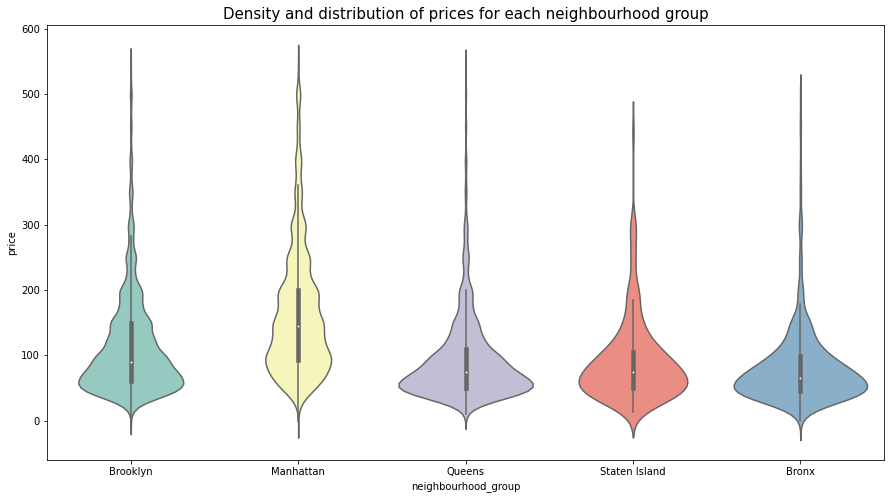

In [0]:
plt.figure(figsize=(15, 8))
plt.title('Density and distribution of prices for each neighbourhood group', fontsize=15)
sns.violinplot(x='neighbourhood_group', y='price', 
               data=nyc_airbnb[nyc_airbnb['price'] < 550], palette='Set3')

Let's examine detail stats by neighbourhood group for better understanding.

In [0]:
# Brooklyn
sub_1_brooklyn = nyc_airbnb.loc[nyc_airbnb['neighbourhood_group'] == 'Brooklyn']
price_sub_1 = sub_1_brooklyn[['price']]

# Manhattan
sub_2_manhattan = nyc_airbnb.loc[nyc_airbnb['neighbourhood_group'] == 'Manhattan']
price_sub_2 = sub_2_manhattan[['price']]

# Queeens
sub_3_queens = nyc_airbnb.loc[nyc_airbnb['neighbourhood_group'] == 'Queens']
price_sub_3 = sub_3_queens[['price']]

# Staten Island
sub_4_staten = nyc_airbnb.loc[nyc_airbnb['neighbourhood_group'] == 'Staten Island']
price_sub_4 = sub_4_staten[['price']]

# Bronx
sub_5_bronx = nyc_airbnb.loc[nyc_airbnb['neighbourhood_group'] == 'Bronx']
price_sub_5 = sub_5_bronx[['price']]

price_list_by_group = [price_sub_1, price_sub_2, price_sub_3, price_sub_4, price_sub_5]

Integrates all individual stats into dataframe.

In [0]:
integ_price_stats_list = []
neigh_groups = nyc_airbnb['neighbourhood_group'].unique().tolist()

for price_group, group_name in zip(price_list_by_group, neigh_groups):
  stats = price_group.describe()  # count / mean / std / 25% / 50% / 75% / max
  stats = stats.iloc[1:]  # mean / std / 25% / 50% / 75% / max
  stats.reset_index(inplace=True)
  stats.rename(columns={'index': 'Stats', 'price': group_name}, inplace=True)
  stats.set_index('Stats', inplace=True)
  integ_price_stats_list.append(stats)

price_stats_df = pd.concat(integ_price_stats_list, axis=1)
price_stats_df

,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Stats,,,,,
mean,124.383207,196.875814,99.517649,114.812332,87.496792
std,186.873538,291.383183,167.102155,277.620403,106.709349
min,0.000000,0.000000,10.000000,13.000000,0.000000
25%,60.000000,95.000000,50.000000,50.000000,45.000000
50%,90.000000,150.000000,75.000000,75.000000,65.000000
75%,150.000000,220.000000,110.000000,110.000000,99.000000
max,10000.000000,10000.000000,10000.000000,5000.000000,2500.000000


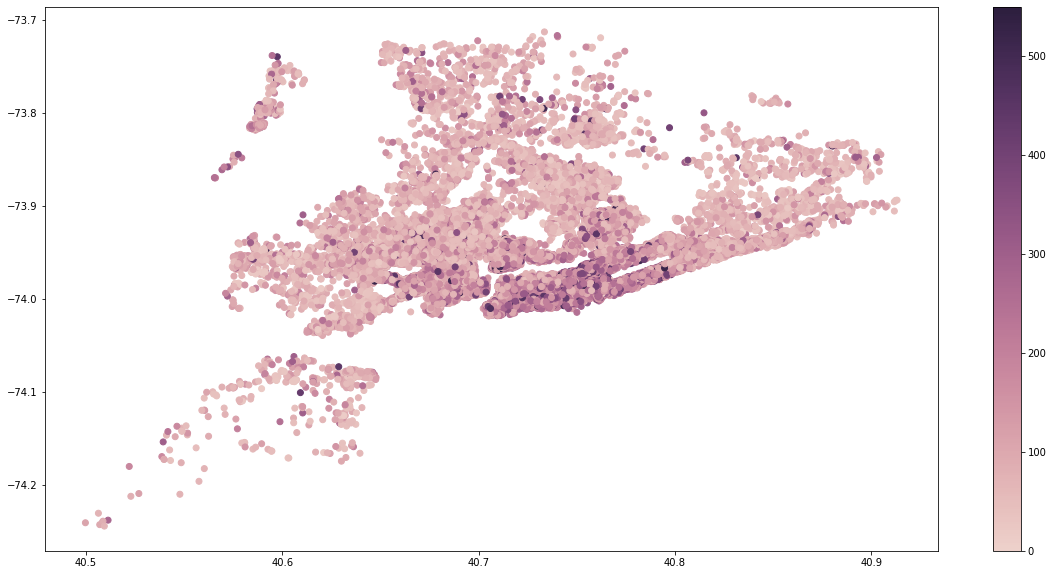

In [0]:
cmap = sns.cubehelix_palette(as_cmap=True)

wo_extreme = nyc_airbnb[nyc_airbnb['price'] < 550]

f, ax = plt.subplots()
f.set_size_inches(20, 10)
points = ax.scatter(wo_extreme['latitude'], wo_extreme['longitude'], 
                    c=wo_extreme['price'], cmap=cmap)
f.colorbar(points)

### Host location distribution

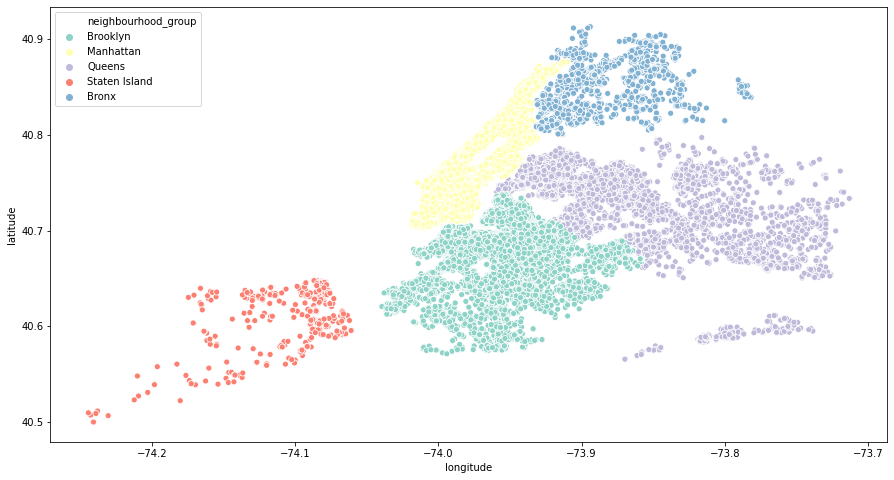

In [0]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=nyc_airbnb, x='longitude', y='latitude', 
                hue='neighbourhood_group', palette='Set3')

## Predictions

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [0]:
nyc_airbnb.drop(['name', 'id'], inplace=True, axis=1)

In [0]:
# encodes categorical values
le = LabelEncoder()

le.fit(nyc_airbnb['neighbourhood_group'])
nyc_airbnb['neighbourhood_group'] = le.transform(nyc_airbnb['neighbourhood_group'])

le.fit(nyc_airbnb['neighbourhood'])
nyc_airbnb['neighbourhood'] = le.transform(nyc_airbnb['neighbourhood'])

le.fit(nyc_airbnb['room_type'])
nyc_airbnb['room_type'] = le.transform(nyc_airbnb['room_type'])

nyc_airbnb.head(5)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
22835,97001292,3,105,40.69085,-73.79916,0,10,1,43,1.68,1,252
34446,205820814,0,96,40.83454,-73.92751,1,10,1,0,0.00,1,180
22287,84497333,2,178,40.72237,-73.99817,1,10,5,2,0.07,1,0
31407,91034542,2,112,40.74408,-73.97803,1,10,5,42,2.87,1,2
23256,52777892,2,201,40.76844,-73.95341,0,10,3,10,0.39,1,0


In [0]:
# records with price zero are sorted on top
nyc_airbnb.sort_values('price', ascending=True, inplace=True)

In [0]:
nyc_airbnb = nyc_airbnb[11:-6]

In [0]:
lm = LinearRegression()

In [0]:
X = nyc_airbnb.drop(['price', 'longitude'], inplace=False, axis=1)
y = nyc_airbnb['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
predictions = lm.predict(X_test)

In [0]:
# Evaluated metrics

mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
r2 = metrics.r2_score(y_test, predictions)

print('MAE (Mean Absolute Error): %s' %mae)
print('MSE (Mean Squared Error): %s' %mse)
print('RMSE (Root mean squared error): %s' %rmse)
print('R2 score: %s' %r2)

MAE (Mean Absolute Error): 71.39239459844293
MSE (Mean Squared Error): 23457.549596105273
RMSE (Root mean squared error): 153.15857663253885
R2 score: 0.14771484151462444


In [0]:
# Avtual vs predicted values

error = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': predictions.flatten()})
error.head(10)

,Actual Values,Predicted Values
0,70,97.074850
1,70,206.988693
2,125,159.444101
3,40,66.074788
4,350,180.042091
5,150,204.530345
6,150,217.569197
7,110,167.140398
8,100,175.178152
9,306,241.448199
